## Spam or Ham (not Spam) Email Text Classification Project using Word2Vec

### Importing needed Modules

In [126]:
import pandas as pd
import numpy as np

import gensim
import gensim.downloader as api
from gensim.utils import simple_preprocess

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, recall_score

from tqdm import tqdm

import matplotlib.pyplot as plt

nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Loading Google's Word2Vec model

In [3]:
w2v = api.load("word2vec-google-news-300")

#Testing if it loaded properly 
w2v["king"]

array([ 1.25976562e-01,  2.97851562e-02,  8.60595703e-03,  1.39648438e-01,
       -2.56347656e-02, -3.61328125e-02,  1.11816406e-01, -1.98242188e-01,
        5.12695312e-02,  3.63281250e-01, -2.42187500e-01, -3.02734375e-01,
       -1.77734375e-01, -2.49023438e-02, -1.67968750e-01, -1.69921875e-01,
        3.46679688e-02,  5.21850586e-03,  4.63867188e-02,  1.28906250e-01,
        1.36718750e-01,  1.12792969e-01,  5.95703125e-02,  1.36718750e-01,
        1.01074219e-01, -1.76757812e-01, -2.51953125e-01,  5.98144531e-02,
        3.41796875e-01, -3.11279297e-02,  1.04492188e-01,  6.17675781e-02,
        1.24511719e-01,  4.00390625e-01, -3.22265625e-01,  8.39843750e-02,
        3.90625000e-02,  5.85937500e-03,  7.03125000e-02,  1.72851562e-01,
        1.38671875e-01, -2.31445312e-01,  2.83203125e-01,  1.42578125e-01,
        3.41796875e-01, -2.39257812e-02, -1.09863281e-01,  3.32031250e-02,
       -5.46875000e-02,  1.53198242e-02, -1.62109375e-01,  1.58203125e-01,
       -2.59765625e-01,  

### Loading the Dataset

In [5]:
data = pd.read_csv("../data/spam.csv", encoding = "ISO-8859-1")
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


### Cleaning the data

In [27]:
# Drops the last three columns due to extra commas at the end of some sentences
cleaned_data = data.iloc[:, :2]

cleaned_data

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [28]:
# Renaming the columns
cleaned_data = cleaned_data.rename(columns = {'v1': 'label', 'v2': 'message'})

In [10]:
cleaned_data

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
# Removing duplicates | Only removed exact duplicates as it only adds bias
cleaned_data.duplicated().sum()

403

In [29]:
cleaned_data.drop_duplicates(inplace = True)

In [13]:
cleaned_data.duplicated().sum()

0

In [30]:
cleaned_data['label'].unique()

array(['ham', 'spam'], dtype=object)

In [33]:
# Converting ham -> 0, spam -> 1
encoder = LabelEncoder()

cleaned_data['label'] = encoder.fit_transform(cleaned_data['label'])

In [39]:
encoder.classes_

array(['ham', 'spam'], dtype=object)

### Text Preprocessing

In [41]:
# Removing special characters and numbers

cleaned_data['message'] = cleaned_data['message'].replace(regex = r'[^a-zA-Z\s+]', value = '')

In [42]:
cleaned_data['message'] = cleaned_data['message'].str.lower()

cleaned_data

,label,message
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...
...,...,...
5567,1,this is the nd time we have tried contact u u...
5568,0,will b going to esplanade fr home
5569,0,pity was in mood for that soany other suggest...
5570,0,the guy did some bitching but i acted like id ...


### Lemmatizing the messages

In [22]:
def lemmatize(document: str) -> list:
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []

    for word in document.split():
        lemmatized_words.append(lemmatizer.lemmatize(word))

    return " ".join(lemmatized_words)

In [43]:
cleaned_data['lemmatized_messages'] = cleaned_data['message'].map(lambda x: lemmatize(x))

In [44]:
cleaned_data

,label,message,lemmatized_messages
0,0,go until jurong point crazy available only in ...,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final...,free entry in a wkly comp to win fa cup final ...
3,0,u dun say so early hor u c already then say,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...,nah i dont think he go to usf he life around h...
...,...,...,...
5567,1,this is the nd time we have tried contact u u...,this is the nd time we have tried contact u u ...
5568,0,will b going to esplanade fr home,will b going to esplanade fr home
5569,0,pity was in mood for that soany other suggest...,pity wa in mood for that soany other suggestion
5570,0,the guy did some bitching but i acted like id ...,the guy did some bitching but i acted like id ...


In [46]:
corpus = cleaned_data['lemmatized_messages'].to_list()

In [49]:
words = []
for sentence in corpus:
    words.append(word_tokenize(sentence))

words

[['go',
  'until',
  'jurong',
  'point',
  'crazy',
  'available',
  'only',
  'in',
  'bugis',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet',
  'cine',
  'there',
  'got',
  'amore',
  'wat'],
 ['ok', 'lar', 'joking', 'wif', 'u', 'oni'],
 ['free',
  'entry',
  'in',
  'a',
  'wkly',
  'comp',
  'to',
  'win',
  'fa',
  'cup',
  'final',
  'tkts',
  'st',
  'may',
  'text',
  'fa',
  'to',
  'to',
  'receive',
  'entry',
  'questionstd',
  'txt',
  'ratetcs',
  'apply',
  'over'],
 ['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say'],
 ['nah',
  'i',
  'dont',
  'think',
  'he',
  'go',
  'to',
  'usf',
  'he',
  'life',
  'around',
  'here',
  'though'],
 ['freemsg',
  'hey',
  'there',
  'darling',
  'it',
  'been',
  'week',
  'now',
  'and',
  'no',
  'word',
  'back',
  'id',
  'like',
  'some',
  'fun',
  'you',
  'up',
  'for',
  'it',
  'still',
  'tb',
  'ok',
  'xxx',
  'std',
  'chgs',
  'to',
  'send',
  'to',
  'rcv'],
 ['even',
  'my',
 

### Word2Vec Model

In [ ]:
# Initializing the model
model = gensim.models.Word2Vec(sentences = words, )

In [51]:
# The vocab used by the model
model.wv.index_to_key

['i',
 'to',
 'you',
 'a',
 'the',
 'u',
 'and',
 'it',
 'in',
 'is',
 'me',
 'my',
 'for',
 'your',
 'of',
 'have',
 'call',
 'that',
 'on',
 'are',
 'im',
 'now',
 'so',
 'not',
 'but',
 'can',
 'at',
 'or',
 'get',
 'be',
 'do',
 'will',
 'with',
 'just',
 'if',
 'we',
 'no',
 'ur',
 'this',
 'up',
 'go',
 'dont',
 'from',
 'when',
 'how',
 'ltgt',
 'out',
 'ok',
 'know',
 'all',
 'what',
 'free',
 'got',
 'like',
 'come',
 'day',
 'then',
 'time',
 'good',
 'am',
 'wa',
 'there',
 'ill',
 'he',
 'want',
 'text',
 'only',
 'love',
 'need',
 'one',
 'going',
 'send',
 'by',
 'lor',
 'about',
 'home',
 'today',
 'see',
 'r',
 'still',
 'back',
 'stop',
 'think',
 'txt',
 'our',
 'take',
 'tell',
 'well',
 'reply',
 'mobile',
 'hi',
 'da',
 'n',
 'new',
 'phone',
 'any',
 'sorry',
 'please',
 'been',
 'ha',
 'make',
 'week',
 'here',
 'some',
 'they',
 'an',
 'night',
 'hey',
 'thing',
 'her',
 'did',
 'cant',
 'oh',
 'much',
 'say',
 'she',
 'na',
 'him',
 'too',
 'great',
 'give',
 '

In [ ]:
# Number of vocab
model.corpus_count

5169

In [ ]:
# Number of epochs used in training the model
model.epochs

5

In [ ]:
# Finding words similar to good
model.wv.similar_by_word("good")

[('day', 0.9992770552635193),
 ('great', 0.9992046356201172),
 ('in', 0.9991424083709717),
 ('my', 0.9991327524185181),
 ('well', 0.9991176724433899),
 ('all', 0.9990966320037842),
 ('happy', 0.9990943074226379),
 ('night', 0.9990885853767395),
 ('of', 0.999066948890686),
 ('thing', 0.9990668892860413)]

In [ ]:
# Finding the vector of good
model.wv['good']

array([-0.37349382,  0.48463446,  0.02528264,  0.06743462,  0.10289673,
       -0.6060715 ,  0.14946671,  0.9017371 , -0.29600814, -0.32746783,
       -0.12697002, -0.50324047, -0.13952325,  0.17125735,  0.17946297,
       -0.29245654,  0.11212405, -0.3233287 , -0.14010139, -0.5890269 ,
        0.06749832,  0.21591334,  0.22533613, -0.31460738, -0.03947063,
        0.1312843 , -0.32227144, -0.2164343 , -0.34501526,  0.12245798,
        0.36571282, -0.15371579,  0.14120758, -0.37465292, -0.28269312,
        0.47537684,  0.02264817, -0.30358893, -0.22785479, -0.5915515 ,
        0.10048579, -0.35312328, -0.18812363,  0.01327406,  0.3110509 ,
       -0.2215546 , -0.38718393, -0.0960009 ,  0.20526332,  0.3457076 ,
        0.2774337 , -0.36951712,  0.0674442 , -0.06040166, -0.13902603,
       -0.03218256,  0.28826573, -0.02424664, -0.36191458,  0.13780159,
        0.03953436,  0.148565  ,  0.1189397 , -0.03943506, -0.64419574,
        0.36186972,  0.25358418,  0.5191916 , -0.5816659 ,  0.43

In [102]:
def avg_word2vec(sentence):
    vector = [model.wv[word] for word in sentence if word in model.wv.index_to_key]

    if vector:
        return np.mean(np.vstack(vector), axis = 0)
    
    else:
        return np.zeros(model.vector_size)

In [107]:
resultant = []

for i in tqdm(range(len(words))):
    resultant.append(avg_word2vec(words[i]))

X = np.vstack(resultant)

100%|██████████| 5169/5169 [00:00<00:00, 10087.12it/s]


In [108]:
# How large the vector is = how many records are there
len(X)

5169

In [109]:
# Setting the X and y
X = np.array(X)
y = cleaned_data['label']

In [110]:
# Confirming size
X.shape

(5169, 100)

### Train-Test split

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Model Training

In [119]:
# Function for generating metrics
def get_metrics(y_actual, y_predicted):
    return (accuracy_score(y_actual, y_predicted), f1_score(y_actual, y_predicted), recall_score(y_actual, y_predicted))

In [127]:
from collections import defaultdict

models = {
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "Suport Vector Machine": SVC()
}

train_metrics = defaultdict(list)

test_metrics = defaultdict(list)

# Model Training
for name, model in models.items():
    print(f"Training {name}")
    model.fit(X_train, y_train)

    # train metrics
    y_pred_train = model.predict(X_train)
    acc, f1, recall = get_metrics(y_train, y_pred_train)

    train_metrics[name].append(acc)
    train_metrics[name].append(f1)
    train_metrics[name].append(recall)

    # test metrics
    y_pred_test = model.predict(X_test)
    acc, f1, recall = get_metrics(y_test, y_pred_test)

    test_metrics[name].append(acc)
    test_metrics[name].append(f1)
    test_metrics[name].append(recall)

Training RandomForestClassifier
Training LogisticRegression
Training Suport Vector Machine


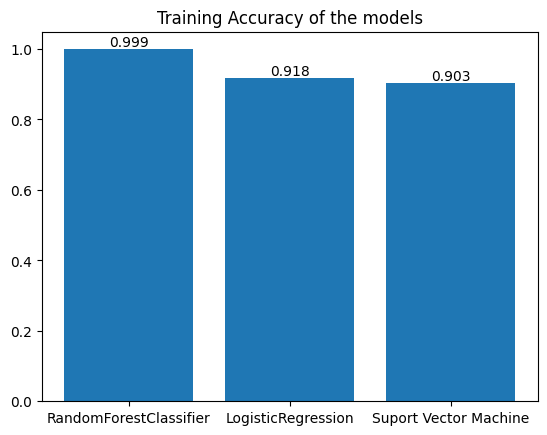

In [128]:
# Graphing training accuracy
accuracies = [acc[0] for acc in train_metrics.values()]

plt.bar(x = train_metrics.keys(), height = accuracies)
for i, v in enumerate(accuracies):
    plt.text(i, v, str(round(v, 3)), ha='center', va='bottom')
plt.title("Training Accuracy of the models")
plt.show()

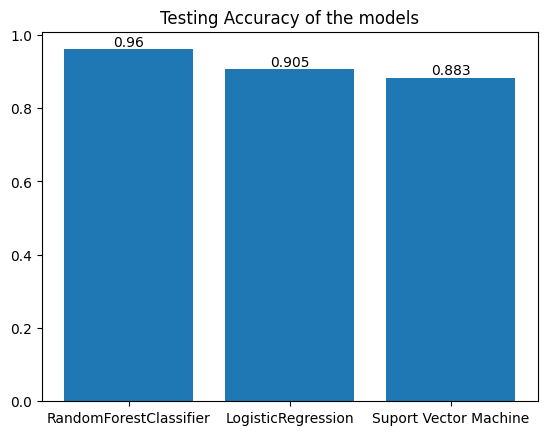

In [129]:
# Graphing testing accuracy
accuracies = [acc[0] for acc in test_metrics.values()]

plt.bar(x = test_metrics.keys(), height = accuracies)
for i, v in enumerate(accuracies):
    plt.text(i, v, str(round(v, 3)), ha='center', va='bottom')
plt.title("Testing Accuracy of the models")
plt.show()

### Conclusion
- RandomForestClassifer model clearly outperforms the Logistic Regression and Suport Vector Machine model in terms of training and test accuracy.
- In-general, ensemble techniques outperform other know supervised machine learning models when Word2Vec is used.
- Comparing the TF-IDF and the Word2Vec approaches, the TF-IDF results in models that perform generally better than the one that are based on Word2Vec trained on the corpus.
- Due to resource constraints, Word2Vec only has a vecotr size of 100, increasing this hyperparameter could lead to a more accurate model
- Random Forest Classifer and other ensemble techniques perform the best or well enough in both TF-IDF and Word2Vec apporoaches